# Step 1: Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import torch
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

c:\Users\ADMIN\Desktop\Multi-Label Classification of Customer Support Tickets with Fine-Tuned BERT\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 2: Load and Preprocess the Dataset

In [2]:
file_path = 'Electronics_5.csv'
df = pd.read_csv(file_path)

In [3]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [4]:
df = df.dropna(subset=['reviewText', 'summary'])
df = df.drop_duplicates(subset=['reviewerID', 'asin'])

In [5]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [6]:
df['text'] = df['reviewText'] + " " + df['summary']

In [7]:
df[['reviewText', 'summary', 'text']].head()

,reviewText,summary,text
0,We got this GPS for my husband who is an (OTR)...,Gotta have GPS!,We got this GPS for my husband who is an (OTR)...
1,"I'm a professional OTR truck driver, and I bou...",Very Disappointed,"I'm a professional OTR truck driver, and I bou..."
2,"Well, what can I say. I've had this unit in m...",1st impression,"Well, what can I say. I've had this unit in m..."
3,"Not going to write a long review, even thought...","Great grafics, POOR GPS","Not going to write a long review, even thought..."
4,I've had mine for a year and here's what we go...,"Major issues, only excuses for support",I've had mine for a year and here's what we go...


In [8]:
sample_df = df.sample(n=100000, random_state=42)

In [9]:
sample_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,text
155882,A2TMWQ2Y5427D1,B0009ORXF2,G. C. Robinson,"[4, 7]",We bought this to use with the Rhapsody-to-go ...,4,Excellent - but Rhapsody-to-go set-up was a bi...,1146873600,"05 6, 2006",We bought this to use with the Rhapsody-to-go ...
816140,A3UPEG3LRWOX16,B003SF6GYS,Alfredo,"[0, 0]",Just what I needed to recharge some of my batt...,4,It Works Well,1372032000,"06 24, 2013",Just what I needed to recharge some of my batt...
471780,A1MKFHRHGKW550,B001GR1C3A,Robert Schuch,"[0, 0]",These discs have media code MCC03RG20 and work...,5,Great disc for professional results,1357344000,"01 5, 2013",These discs have media code MCC03RG20 and work...
340520,A12S5Y4JKJD0BZ,B000WL6YY8,Jumbaliah,"[3, 3]","As many others have noted, this item is a rede...",4,Buying in 2014?! READ THIS!!!!,1404518400,"07 5, 2014","As many others have noted, this item is a rede..."
926902,A1JY0K8IEVS5U7,B004C35KRO,Amazon Customer,"[0, 0]",I have two of these for my Galaxy tablet - the...,5,Solid support,1387584000,"12 21, 2013",I have two of these for my Galaxy tablet - the...


In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

sample_df['cleaned_text'] = sample_df['text'].apply(clean_text)

In [11]:
sample_df[['text', 'cleaned_text']].head()

,text,cleaned_text
155882,We bought this to use with the Rhapsody-to-go ...,we bought this to use with the rhapsodytogo se...
816140,Just what I needed to recharge some of my batt...,just what i needed to recharge some of my batt...
471780,These discs have media code MCC03RG20 and work...,these discs have media code mcc03rg20 and work...
340520,"As many others have noted, this item is a rede...",as many others have noted this item is a redes...
926902,I have two of these for my Galaxy tablet - the...,i have two of these for my galaxy tablet they ...


# Step 3: Assign Labels and Binarize

In [12]:
categories = ['product_quality', 'customer_service', 'price', 'functionality', 'ease_of_use']
sample_df['labels'] = sample_df['cleaned_text'].apply(lambda x: np.random.choice(categories, size=np.random.randint(1, 3), replace=False).tolist())

In [13]:
sample_df[['cleaned_text', 'labels']].head()

,cleaned_text,labels
155882,we bought this to use with the rhapsodytogo se...,"[ease_of_use, product_quality]"
816140,just what i needed to recharge some of my batt...,[price]
471780,these discs have media code mcc03rg20 and work...,[functionality]
340520,as many others have noted this item is a redes...,[ease_of_use]
926902,i have two of these for my galaxy tablet they ...,[product_quality]


In [14]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(sample_df['labels'])

In [15]:
pd.DataFrame(y, columns=mlb.classes_).head()

,customer_service,ease_of_use,functionality,price,product_quality
0,0,1,0,0,1
1,0,0,0,1,0
2,0,0,1,0,0
3,0,1,0,0,0
4,0,0,0,0,1


# Step 4: Tokenization using BERT

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=512)

encodings = sample_df['cleaned_text'].apply(tokenize_function)
input_ids = [encoding['input_ids'] for encoding in encodings]
attention_masks = [encoding['attention_mask'] for encoding in encodings]

In [17]:
np.array(input_ids).shape, np.array(attention_masks).shape

((100000, 512), (100000, 512))

# Step 5: Train-Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(list(zip(input_ids, attention_masks)), y, test_size=0.2, random_state=42)

In [19]:
len(X_train), len(X_test), y_train.shape, y_test.shape

(80000, 20000, (80000, 5), (20000, 5))

# Step 6: Model Preparation

In [20]:
device = torch.device("cpu")
X_train_sampled = X_train[:500]
y_train_sampled = y_train[:500]

X_train_input_ids = torch.tensor([x[0][:128] for x in X_train_sampled], dtype=torch.long)
X_train_attention_mask = torch.tensor([x[1][:128] for x in X_train_sampled], dtype=torch.long)
y_train_tensor = torch.tensor(y_train_sampled, dtype=torch.float)

train_data = TensorDataset(X_train_input_ids, X_train_attention_mask, y_train_tensor)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(mlb.classes_))
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\ADMIN\Desktop\Multi-Label Classification of Customer Support Tickets with Fine-Tuned BERT\venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Step 7: Training the Model

In [21]:
epochs = 10
grad_accum_steps = 2

model.train()
for epoch in range(epochs):
    total_loss = 0
    start_time = time.time()
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
    
    for step, batch in enumerate(progress_bar):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss / grad_accum_steps
        loss.backward()
        
        if (step + 1) % grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * grad_accum_steps
        elapsed_time = time.time() - start_time
        avg_time_per_batch = elapsed_time / (step + 1)
        estimated_time_left = avg_time_per_batch * (len(train_dataloader) - step - 1)
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}", "ETA": f"{estimated_time_left:.2f}s"})
    
    print(f"Epoch {epoch + 1}/{epochs} completed! Average Loss: {total_loss / len(train_dataloader):.4f}")

print("Training completed successfully!")

Epoch 1/10: 100%|██████████| 16/16 [08:06<00:00, 30.41s/it, Loss=0.3046, ETA=0.00s]  


Epoch 1/10 completed! Average Loss: 0.6433


Epoch 2/10: 100%|██████████| 16/16 [31:59<00:00, 119.97s/it, Loss=0.3065, ETA=0.00s]    


Epoch 2/10 completed! Average Loss: 0.6095


Epoch 3/10: 100%|██████████| 16/16 [06:02<00:00, 22.65s/it, Loss=0.2980, ETA=0.00s]  


Epoch 3/10 completed! Average Loss: 0.6054


Epoch 4/10: 100%|██████████| 16/16 [10:01<00:00, 37.61s/it, Loss=0.2928, ETA=0.00s]  


Epoch 4/10 completed! Average Loss: 0.6030


Epoch 5/10: 100%|██████████| 16/16 [15:29<00:00, 58.09s/it, Loss=0.2970, ETA=0.00s]   


Epoch 5/10 completed! Average Loss: 0.5986


Epoch 6/10: 100%|██████████| 16/16 [05:22<00:00, 20.13s/it, Loss=0.2931, ETA=0.00s]  


Epoch 6/10 completed! Average Loss: 0.5868


Epoch 7/10: 100%|██████████| 16/16 [06:43<00:00, 25.23s/it, Loss=0.2811, ETA=0.00s]  


Epoch 7/10 completed! Average Loss: 0.5686


Epoch 8/10: 100%|██████████| 16/16 [06:32<00:00, 24.52s/it, Loss=0.2634, ETA=0.00s]  


Epoch 8/10 completed! Average Loss: 0.5451


Epoch 9/10: 100%|██████████| 16/16 [05:48<00:00, 21.80s/it, Loss=0.2362, ETA=0.00s]  


Epoch 9/10 completed! Average Loss: 0.5150


Epoch 10/10: 100%|██████████| 16/16 [08:07<00:00, 30.49s/it, Loss=0.2242, ETA=0.00s]  

Epoch 10/10 completed! Average Loss: 0.4914
Training completed successfully!


# Step 8: Evaluation

In [22]:
model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    for batch in tqdm(train_dataloader, desc="Evaluating"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.sigmoid(logits).cpu().numpy()
        preds = (preds > 0.3).astype(int)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds)

accuracy = accuracy_score(true_labels, pred_labels)
accuracy=accuracy
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=mlb.classes_))

Evaluating: 100%|██████████| 16/16 [01:54<00:00,  7.18s/it]


Model Accuracy: 0.1160

Classification Report:
                  precision    recall  f1-score   support

customer_service       0.62      0.88      0.73       157
     ease_of_use       0.42      0.90      0.57       162
   functionality       0.83      0.90      0.86       144
           price       0.37      0.95      0.54       135
 product_quality       0.37      0.99      0.54       149

       micro avg       0.47      0.92      0.62       747
       macro avg       0.52      0.92      0.65       747
    weighted avg       0.52      0.92      0.65       747
     samples avg       0.51      0.93      0.63       747



c:\Users\ADMIN\Desktop\Multi-Label Classification of Customer Support Tickets with Fine-Tuned BERT\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Step 9: Save Model and Tokenizer

In [23]:
model.save_pretrained('fine_tuned_bert')
tokenizer.save_pretrained('fine_tuned_bert')
torch.save(optimizer.state_dict(), 'optimizer.pth')

# Step 10: Prediction Function

In [24]:
def predict(text):
    cleaned_text = clean_text(text)
    encoding = tokenizer(cleaned_text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
    encoding = {key: value.to(device) for key, value in encoding.items()}
    model.eval()
    with torch.no_grad():
        output = model(**encoding)
        logits = output.logits
        preds = torch.sigmoid(logits).cpu().numpy()
    predictions = (preds >= 0.3).astype(int)
    unique_predictions = np.unique(mlb.classes_[predictions.flatten()])
    return unique_predictions


sample_text = "This product is amazing, it works really well and is easy to use!"
predicted_labels = predict(sample_text)
print(f"Predicted Labels: {predicted_labels}")


Predicted Labels: ['customer_service' 'ease_of_use']


# Step 11: Data Analysis and Visualization with Matplotlib

In [25]:
import matplotlib.pyplot as plt


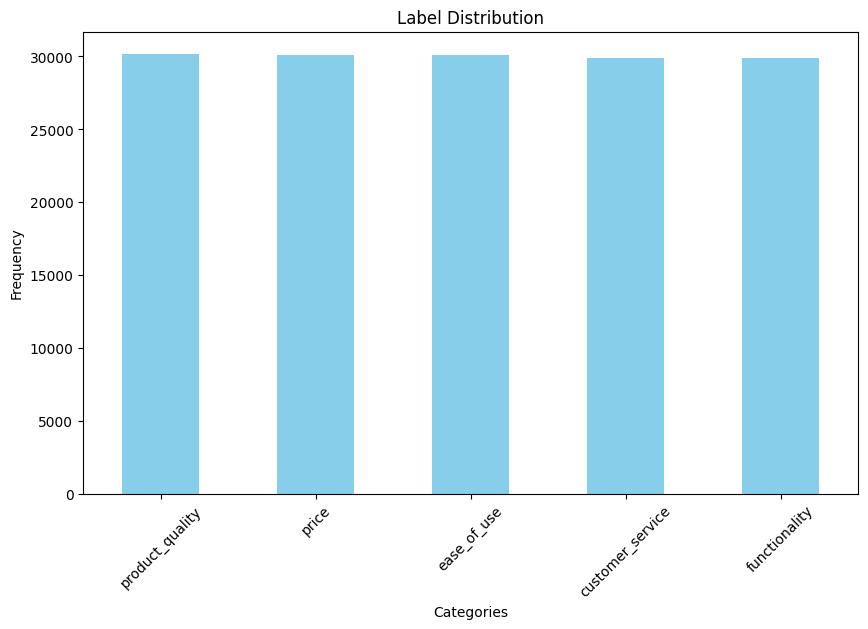

In [26]:
# 1. Label Distribution

all_labels = [label for sublist in sample_df['labels'] for label in sublist]
label_counts = pd.Series(all_labels).value_counts()

# Plot the label distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

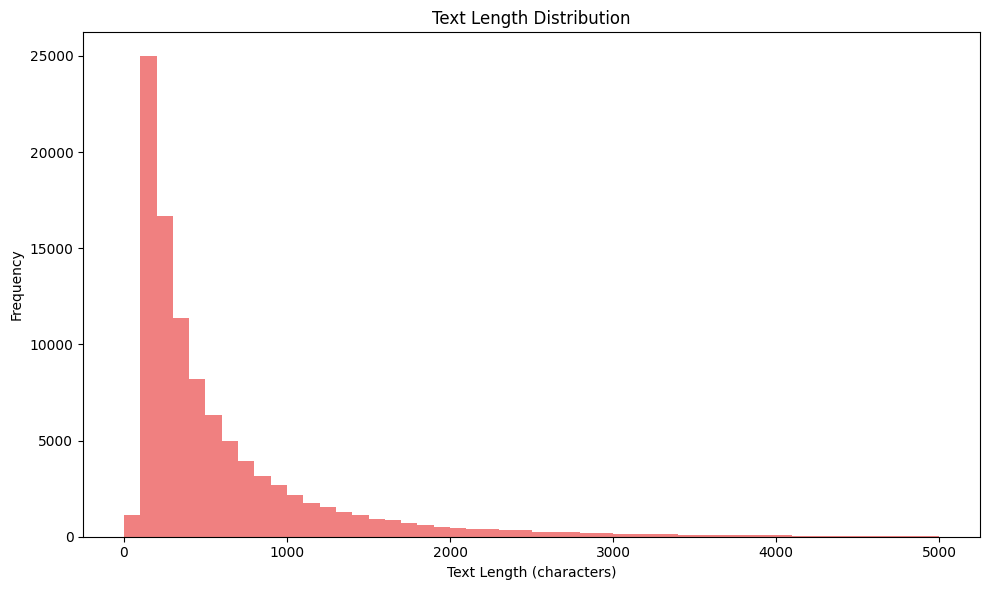

In [27]:
# 2. Text Length Distribution

sample_df['text_length'] = sample_df['cleaned_text'].apply(len)

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(sample_df['text_length'], bins=50, color='lightcoral', range=(0, 5000))
plt.title('Text Length Distribution')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.tight_layout()  
plt.show()

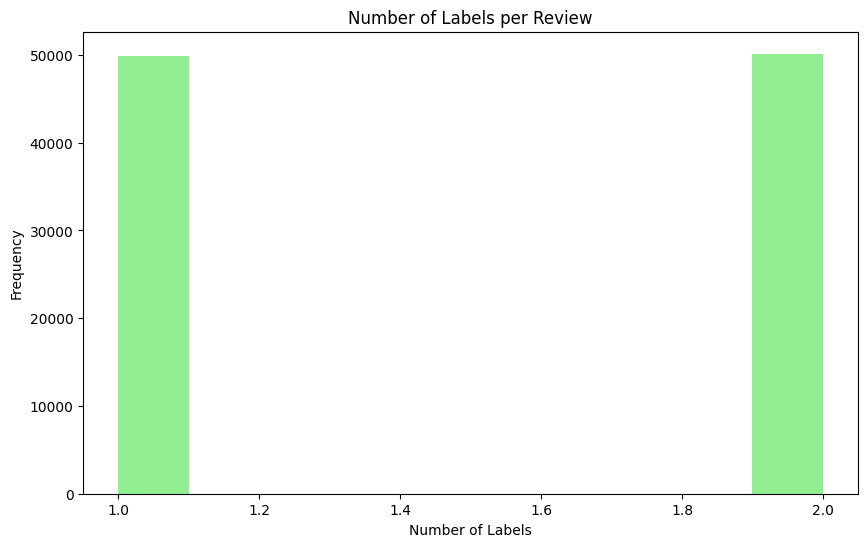

In [28]:
# 3. Distribution of Number of Labels per Review

num_labels_per_review = sample_df['labels'].apply(len)

# Plot the distribution of number of labels
plt.figure(figsize=(10, 6))
plt.hist(num_labels_per_review, bins=10, color='lightgreen')
plt.title('Number of Labels per Review')
plt.xlabel('Number of Labels')
plt.ylabel('Frequency')
plt.show()

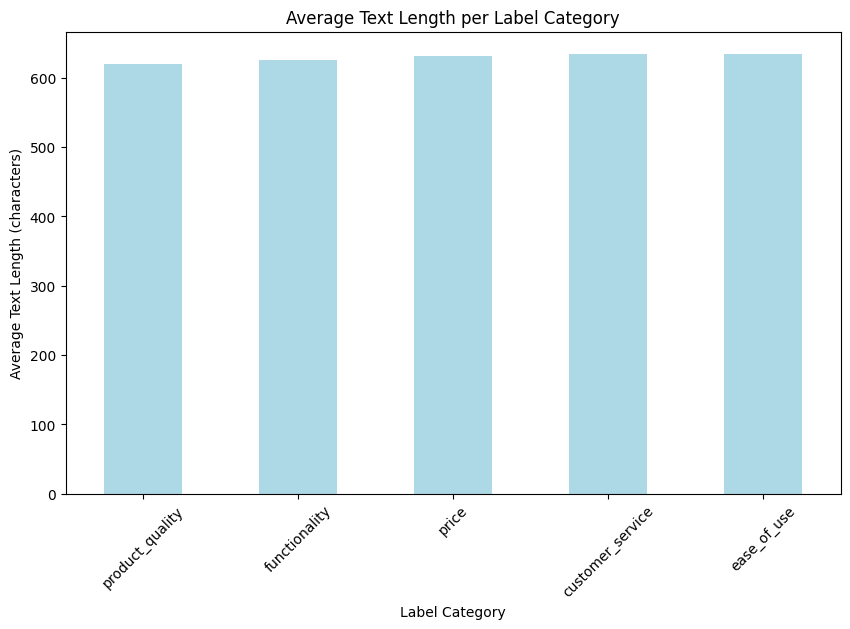

In [29]:
# 4. Average Text Length per Label Category

category_avg_text_length = sample_df.explode('labels').groupby('labels')['text_length'].mean()

# Plot the average text length per category
plt.figure(figsize=(10, 6))
category_avg_text_length.sort_values().plot(kind='bar', color='lightblue')
plt.title('Average Text Length per Label Category')
plt.xlabel('Label Category')
plt.ylabel('Average Text Length (characters)')
plt.xticks(rotation=45)
plt.show()